In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import pdb
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.style as style
import datetime
import json
from imutils import paths
import cv2

% matplotlib inline
style.use('seaborn-whitegrid')
warnings.filterwarnings(action='once')

UsageError: Line magic function `%` not found.


Currently processing Palm data.
Currently processing L data.
Currently processing Fist data.
Currently processing Thumb data.
Currently processing Palm data.
Currently processing L data.
Currently processing Fist data.
Currently processing Thumb data.
X_data shape: (10880, 144, 256, 3)
y_data shape: (10880, 4)


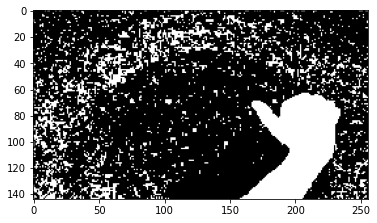

In [30]:
from keras.utils import to_categorical

def load_image(path):
    """Opens image and converts to array

    Args:
        path (str): The file location of the image

    Returns:
        img (array): An array representing the image
    """

    img = cv2.imread(path)
    img = np.array(img)
    return img

def process_data(X_data, y_data):
    """Converts each element in binary frame with dimensions MxNx1 to MxNx3 to mimic RGB pixel count

    Args:
        X_data (list): List of arrays representing MxNx1 binary images 
        y_data (list): List of integers representing image classification category 

    Returns:
        X_data (array): Array of arrays representing MXNx3 binary images
        y_data (array): Array of integers representing image classification category 
    """
    
    X_data_proc = []
    blurValue = 25
    for img in X_data:
        if img.shape != (144,256,3):
            img = cv2.resize(img, dsize=(256,144), interpolation=cv2.INTER_LINEAR)
        (_, img) = cv2.threshold(img, 25, 255, cv2.THRESH_BINARY)
        X_data_proc.append(img)
    X_data = np.array(X_data_proc, dtype = 'float32')
    X_data /= 255
    y_data = np.array(y_data)
    return X_data, y_data

def dhash(image, hashSize=8):
    # convert the image to grayscale and resize the grayscale image,
    # adding a single column (width) so we can compute the horizontal
    # gradient
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (hashSize + 1, hashSize))
    
    # compute the (relative) horizontal gradient between adjacent
    # column pixels
    diff = resized[:, 1:] > resized[:, :-1]
    
    # convert the difference image to a hash and return it
    return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])

def get_paths(abs_paths):
    
    # consolidate all image paths to single list
    paths_dict = {}
    total_count = 0
    for path in abs_paths:
        
        # delete duplicates for each directory
        hashes = {}
        for directory, subdirectories, files in os.walk(path):
            for file in files:
                file_path = os.path.join(directory, file)
                
                # load the input image and compute the hash
                image = cv2.imread(file_path)
                h = dhash(image)

                # grab all image paths with that hash, add the current image path to it, and store the list back in the hashes dictionary
                p = hashes.get(h, '')
                if p == '':
                    hashes[h] = file_path
        unique_paths = list(hashes.values())                
        paths_dict[path] = unique_paths  
        total_count += len(unique_paths) 
    paths_dict['total_count'] = total_count
    
    return paths_dict

def get_data(paths_dict, cat_num, max_count):

    # load and process image 
    total_count = paths_dict['total_count']
    X_data = []
    for path in list(paths_dict.keys())[:-1]: 
        image_paths = paths_dict[path]
        keep_count = round(max_count*len(image_paths)/total_count)
        random_indices = np.random.choice(len(image_paths), size=keep_count, replace=False)
        for file_path in [image_paths[i] for i in random_indices]:

            # choose number of instances from each directory proportional to total number available 
            img = load_image(file_path)
            X_data.append(img)
    y_data = [cat_num for i in range(len(X_data))]
    X_data, y_data = process_data(X_data, y_data)
    
    return X_data, y_data

# relative paths of gesture image directories
pa_input_dirs = ['2021_02_07_T22_01_32_palm', 'Kaggle_data//closed_palm']
l_input_dirs = ['2021_02_07_T22_02_36_L//all_data', 'Kaggle_data//l']
fi_input_dirs = ['2021_02_01_T14_28_23_fist//all_data', 'Kaggle_data//fist']
th_input_dirs = ['2021_02_07_T22_03_02_thumbs_up//all_data', 'Kaggle_data//thumb']

# dictionary mapping gesture abbreviation to category number, gesture name, and gesture directory
gestures_dict = {
    'pa': [0, 'Palm', pa_input_dirs],
    'l_': [1, 'L', l_input_dirs],
    'fi': [2, 'Fist', fi_input_dirs],
    'th': [3, 'Thumb', th_input_dirs],
    }

# for each gesture, add images and integer corresponding to gesture to X_data and y_data arrays, respectively 
X_data = []
y_data = []
paths_dicts = {}
max_count = -1 # number of instances to keep per gesture
for key in list(gestures_dict.keys()):
    cat_num = gestures_dict[key][0]
    name = gestures_dict[key][1]
    dirs = gestures_dict[key][2]
    print(f'Currently processing {name} data.')
    paths_dict = get_paths(dirs)
    paths_dicts[key] = paths_dict
    if paths_dict['total_count'] < max_count or max_count < 0:
        max_count = paths_dict['total_count']
        
for key in list(gestures_dict.keys()):
    cat_num = gestures_dict[key][0]
    name = gestures_dict[key][1]
    print(f'Currently processing {name} data.')
    X_data_gest, y_data_gest = get_data(paths_dicts[key], cat_num, max_count)
    try:
        X_data = np.concatenate((X_data_gest, X_data), axis=0)
        y_data = np.concatenate((y_data_gest, y_data), axis=0)
    except:
        X_data = X_data_gest
        y_data = y_data_gest

# one-hot encode gesture categories 
y_data = to_categorical(y_data)

# Print resultant shapes and sample image
print(f'X_data shape: {X_data.shape}')
print(f'y_data shape: {y_data.shape}')
plt.imshow(X_data[0])

# import time
# for i in X_data:
#     plt.imshow(i)
#     plt.show()

## Collecting and preparing images for training

### Generating augmented images

In [31]:
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import math
import cv2
import os

def rotate(frame):
    """Generate rotated versions of image.

    Args:
        frame (array): Array representing original image

    Returns:
        rotated_frames (list): List of arrays representing rotated images
    """

    # flip image about x-axis
    frame_flipped = tf.image.rot90(frame)
    frame_flipped = tf.image.rot90(frame_flipped)
    frame_flipped = np.array(frame_flipped)
    frame_flipped = cv2.cvtColor(frame_flipped, cv2.COLOR_BGR2GRAY)
    
    datagen = ImageDataGenerator(horizontal_flip=True)
    frame_ext = frame.reshape((1,) + frame.shape) 
    for frame_mirrored in datagen.flow(frame_ext, batch_size=1):
        # mirror image about y-axis
        frame_mirrored = frame_mirrored.reshape((144,256,3))

        # flip and mirror image
        frame_mirrored_flipped = tf.image.rot90(frame_mirrored)
        frame_mirrored_flipped = tf.image.rot90(frame_mirrored_flipped)
        frame_mirrored_flipped = np.array(frame_mirrored_flipped)
        frame_mirrored_flipped = cv2.cvtColor(frame_mirrored_flipped, cv2.COLOR_BGR2GRAY)
        
        frame_mirrored = cv2.cvtColor(frame_mirrored, cv2.COLOR_BGR2GRAY)
        break # break to avoid generating multiple copies of mirrored images

    # package results in list
    rotated_frames = []
    rotated_frames.append(frame_flipped)
    rotated_frames.append(frame_mirrored)
    rotated_frames.append(frame_mirrored_flipped)
    return rotated_frames

def process_data(X_data, y_data):
    """Converts each binary frame with dimensions MxNx1 to MxNx3 to mimic RGB pixel count
    Note: This is different than process_data above because it does not include scaling pixel values

    Args:
        X_data (list): List of arrays representing MxNx1 binary images 
        y_data (list): List of integers representing image classification category 

    Returns:
        X_data (array): Array of arrays representing MXNx3 binary images
        y_data (array): Array of integers representing image classification category 
    """
    
    X_data = np.array(X_data, dtype = 'float32')
    X_data = np.stack((X_data,)*3, axis=-1)
    y_data = np.array(y_data)
    return X_data, y_data

# Generate rotate images and aggregate with original data
X_data_rot = []
y_data_rot = []
for i in range(len(X_data)):
    image = X_data[i]
    rotated_frames = rotate(image)
    X_data_rot.extend(rotated_frames)
    for j in range(len(rotated_frames)):
        y_data_rot.append(y_data[i])
X_data_rot, y_data_rot = process_data(X_data_rot, y_data_rot)
X_data_all = np.append(X_data, X_data_rot, axis=0)
y_data_all = np.append(y_data, y_data_rot, axis=0)

In [32]:
X_data_all.shape

(43520, 144, 256, 3)

### Building initial models

In [9]:
import tensorflow as tf
import inspect
from tqdm import tqdm
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense
from keras.models import Sequential
from sklearn.model_selection import train_test_split

# compile all available Keras models
model_dictionary = {m[0]:m[1] for m in inspect.getmembers(tf.keras.applications, inspect.isfunction)}

# split data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, stratify=y_data) # CHANGE to X_data_all
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train)

# maximum number of epochs for model evaulation
max_epochs = 20

# callback functions
model_dir = os.path.join(os.getcwd(), 'models')
model_checkpoint = ModelCheckpoint(filepath=model_dir, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', 
                            min_delta=0,
                            patience=10,
                            verbose=1,
                            mode='auto',
                            restore_best_weights=True)

# create model
height = X_train.shape[1]
width = X_train.shape[2]
num_categories = y_train.shape[1]
try: 
    assert X_train.shape[3] == 3
except AssertionError:
    print(f'[ERROR] Training data has {X_train.shape[3]} color layers. Model requires 3.')

# Loop over each model available in Keras
model_benchmarks = {'model_name': [], 'num_model_params': [], 'validation_accuracy': []}
for model_name, model in tqdm(model_dictionary.items()):  
    
    # skip NAS models since they require 331x331x3 input shape
    if model_name in ['NASNetLarge', 'NASNetMobile']:
        pass
    else:
        # load the pre-trained model with global average pooling as the last layer and freeze the model weights
        pre_trained_model = model(weights='imagenet', include_top=False, pooling='avg', input_shape=(height, width, 3))
        pre_trained_model.trainable = False
        
        # custom modifications on top of pre-trained model and fit
        clf_model = Sequential()
        clf_model.add(pre_trained_model)
        clf_model.add(Dense(num_categories, activation='softmax'))
        clf_model.compile(
            optimizer='Adam', 
            loss='categorical_crossentropy', 
            metrics=['categorical_accuracy'], 
            )
        history = clf_model.fit(X_train, y_train, epochs=max_epochs, batch_size=64, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping, model_checkpoint])

        # Calculate all relevant metrics
        model_benchmarks['model_name'].append(model_name)
        model_benchmarks['num_model_params'].append(pre_trained_model.count_params())
        model_benchmarks['validation_accuracy'].append(history.history['val_categorical_accuracy'][-1])

  0%|                                                                                                                                                                                                                                                                          | 0/28 [00:00<?, ?it/s]

Epoch 1/20
90/90 [==============================] - 268s 3s/step - loss: 0.9049 - categorical_accuracy: 0.6773 - val_loss: 0.3788 - val_categorical_accuracy: 0.8938
INFO:tensorflow:Assets written to: C:\Users\clemo\git\gesture_recognition\data_collection_model_preparation\models\assets
Epoch 2/20
90/90 [==============================] - 391s 4s/step - loss: 0.3115 - categorical_accuracy: 0.9226 - val_loss: 0.2461 - val_categorical_accuracy: 0.9422
INFO:tensorflow:Assets written to: C:\Users\clemo\git\gesture_recognition\data_collection_model_preparation\models\assets
Epoch 3/20
90/90 [==============================] - 430s 5s/step - loss: 0.2149 - categorical_accuracy: 0.9534 - val_loss: 0.1958 - val_categorical_accuracy: 0.9563
INFO:tensorflow:Assets written to: C:\Users\clemo\git\gesture_recognition\data_collection_model_preparation\models\assets
Epoch 4/20
90/90 [==============================] - 593s 7s/step - loss: 0.1636 - categorical_accuracy: 0.9642 - val_loss: 0.1553 - val_cat

  4%|████████▉                                                                                                                                                                                                                                                | 1/28 [4:22:49<118:16:18, 15769.57s/it]

Epoch 1/20
90/90 [==============================] - 342s 4s/step - loss: 0.8628 - categorical_accuracy: 0.6752 - val_loss: 0.2595 - val_categorical_accuracy: 0.9500
Epoch 2/20
90/90 [==============================] - 354s 4s/step - loss: 0.2292 - categorical_accuracy: 0.9533 - val_loss: 0.1598 - val_categorical_accuracy: 0.9641
Epoch 3/20
90/90 [==============================] - 327s 4s/step - loss: 0.1390 - categorical_accuracy: 0.9715 - val_loss: 0.1099 - val_categorical_accuracy: 0.9750
Epoch 4/20
90/90 [==============================] - 323s 4s/step - loss: 0.1045 - categorical_accuracy: 0.9809 - val_loss: 0.0868 - val_categorical_accuracy: 0.9844
Epoch 5/20
90/90 [==============================] - 322s 4s/step - loss: 0.0787 - categorical_accuracy: 0.9878 - val_loss: 0.0719 - val_categorical_accuracy: 0.9891
Epoch 6/20
90/90 [==============================] - 326s 4s/step - loss: 0.0691 - categorical_accuracy: 0.9891 - val_loss: 0.0601 - val_categorical_accuracy: 0.9891
Epoch 7/20

  7%|█████████████████▋                                                                                                                                                                                                                                      | 2/28 [10:07:14<134:41:22, 18649.31s/it]

Epoch 1/20
90/90 [==============================] - 398s 4s/step - loss: 0.6996 - categorical_accuracy: 0.7770 - val_loss: 0.2277 - val_categorical_accuracy: 0.9641
Epoch 2/20
90/90 [==============================] - 387s 4s/step - loss: 0.2031 - categorical_accuracy: 0.9553 - val_loss: 0.1356 - val_categorical_accuracy: 0.9812
Epoch 3/20
90/90 [==============================] - 393s 4s/step - loss: 0.1276 - categorical_accuracy: 0.9748 - val_loss: 0.0983 - val_categorical_accuracy: 0.9859
Epoch 4/20
90/90 [==============================] - 392s 4s/step - loss: 0.0912 - categorical_accuracy: 0.9821 - val_loss: 0.0724 - val_categorical_accuracy: 0.9906
Epoch 5/20
90/90 [==============================] - 392s 4s/step - loss: 0.0730 - categorical_accuracy: 0.9900 - val_loss: 0.0595 - val_categorical_accuracy: 0.9937
Epoch 6/20
90/90 [==============================] - 395s 4s/step - loss: 0.0593 - categorical_accuracy: 0.9907 - val_loss: 0.0489 - val_categorical_accuracy: 0.9953
Epoch 7/20

 11%|██████████████████████████▌                                                                                                                                                                                                                             | 3/28 [13:30:22<109:01:11, 15698.87s/it]

Epoch 1/20
90/90 [==============================] - 150s 2s/step - loss: 1.3968 - categorical_accuracy: 0.2617 - val_loss: 1.3817 - val_categorical_accuracy: 0.2484
Epoch 2/20
90/90 [==============================] - 135s 2s/step - loss: 1.3906 - categorical_accuracy: 0.2593 - val_loss: 1.3752 - val_categorical_accuracy: 0.3359
Epoch 3/20
90/90 [==============================] - 136s 2s/step - loss: 1.3837 - categorical_accuracy: 0.2838 - val_loss: 1.3757 - val_categorical_accuracy: 0.3219
Epoch 4/20
90/90 [==============================] - 138s 2s/step - loss: 1.3817 - categorical_accuracy: 0.2800 - val_loss: 1.3739 - val_categorical_accuracy: 0.2578
Epoch 5/20
90/90 [==============================] - 138s 2s/step - loss: 1.3822 - categorical_accuracy: 0.2798 - val_loss: 1.3721 - val_categorical_accuracy: 0.2703
Epoch 6/20
90/90 [==============================] - 138s 2s/step - loss: 1.3792 - categorical_accuracy: 0.2942 - val_loss: 1.3837 - val_categorical_accuracy: 0.3187
Epoch 7/20

 14%|███████████████████████████████████▌                                                                                                                                                                                                                     | 4/28 [14:14:31<70:18:49, 10547.08s/it]

Restoring model weights from the end of the best epoch.
Epoch 00019: early stopping
Epoch 1/20
90/90 [==============================] - 206s 2s/step - loss: 1.4038 - categorical_accuracy: 0.2455 - val_loss: 1.3952 - val_categorical_accuracy: 0.2516
Epoch 2/20
90/90 [==============================] - 190s 2s/step - loss: 1.3963 - categorical_accuracy: 0.2597 - val_loss: 1.3833 - val_categorical_accuracy: 0.2500
Epoch 3/20
90/90 [==============================] - 191s 2s/step - loss: 1.3852 - categorical_accuracy: 0.2807 - val_loss: 1.3980 - val_categorical_accuracy: 0.2500
Epoch 4/20
90/90 [==============================] - 191s 2s/step - loss: 1.3882 - categorical_accuracy: 0.2782 - val_loss: 1.3815 - val_categorical_accuracy: 0.2500
Epoch 5/20
90/90 [==============================] - 192s 2s/step - loss: 1.3874 - categorical_accuracy: 0.2743 - val_loss: 1.3777 - val_categorical_accuracy: 0.3125
Epoch 6/20
90/90 [==============================] - 192s 2s/step - loss: 1.3846 - categoric

 18%|████████████████████████████████████████████▋                                                                                                                                                                                                             | 5/28 [15:05:58<50:11:48, 7856.89s/it]

Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
Epoch 1/20
90/90 [==============================] - 216s 2s/step - loss: 1.3968 - categorical_accuracy: 0.2456 - val_loss: 1.3846 - val_categorical_accuracy: 0.3219
Epoch 2/20
90/90 [==============================] - 202s 2s/step - loss: 1.3901 - categorical_accuracy: 0.2710 - val_loss: 1.3858 - val_categorical_accuracy: 0.2500
Epoch 3/20
90/90 [==============================] - 202s 2s/step - loss: 1.3906 - categorical_accuracy: 0.2641 - val_loss: 1.3773 - val_categorical_accuracy: 0.3250
Epoch 4/20
90/90 [==============================] - 204s 2s/step - loss: 1.3859 - categorical_accuracy: 0.2757 - val_loss: 1.3784 - val_categorical_accuracy: 0.2562
Epoch 5/20
90/90 [==============================] - 202s 2s/step - loss: 1.3892 - categorical_accuracy: 0.2722 - val_loss: 1.3807 - val_categorical_accuracy: 0.3141
Epoch 6/20
90/90 [==============================] - 202s 2s/step - loss: 1.3841 - categoric

 21%|█████████████████████████████████████████████████████▌                                                                                                                                                                                                    | 6/28 [15:50:09<37:11:49, 6086.81s/it]

Restoring model weights from the end of the best epoch.
Epoch 00013: early stopping
Epoch 1/20
90/90 [==============================] - 283s 3s/step - loss: 1.3863 - categorical_accuracy: 0.2740 - val_loss: 1.3553 - val_categorical_accuracy: 0.3250
Epoch 2/20
90/90 [==============================] - 271s 3s/step - loss: 1.3676 - categorical_accuracy: 0.2962 - val_loss: 1.3351 - val_categorical_accuracy: 0.3125
Epoch 3/20
90/90 [==============================] - 281s 3s/step - loss: 1.3588 - categorical_accuracy: 0.3056 - val_loss: 1.3345 - val_categorical_accuracy: 0.3719
Epoch 4/20
90/90 [==============================] - 269s 3s/step - loss: 1.3565 - categorical_accuracy: 0.2904 - val_loss: 1.3357 - val_categorical_accuracy: 0.3125
Epoch 5/20
90/90 [==============================] - 269s 3s/step - loss: 1.3517 - categorical_accuracy: 0.3058 - val_loss: 1.3310 - val_categorical_accuracy: 0.3047
Epoch 6/20
90/90 [==============================] - 269s 3s/step - loss: 1.3608 - categoric

 25%|██████████████████████████████████████████████████████████████▌                                                                                                                                                                                           | 7/28 [16:49:12<30:39:17, 5255.10s/it]

Restoring model weights from the end of the best epoch.
Epoch 00013: early stopping
Epoch 1/20
90/90 [==============================] - 385s 4s/step - loss: 1.3993 - categorical_accuracy: 0.2559 - val_loss: 1.4046 - val_categorical_accuracy: 0.3141
Epoch 2/20
90/90 [==============================] - 373s 4s/step - loss: 1.3974 - categorical_accuracy: 0.2585 - val_loss: 1.3840 - val_categorical_accuracy: 0.2500
Epoch 3/20
90/90 [==============================] - 370s 4s/step - loss: 1.3950 - categorical_accuracy: 0.2569 - val_loss: 1.3882 - val_categorical_accuracy: 0.2500
Epoch 4/20
90/90 [==============================] - 370s 4s/step - loss: 1.3981 - categorical_accuracy: 0.2620 - val_loss: 1.3824 - val_categorical_accuracy: 0.3219
Epoch 5/20
90/90 [==============================] - 373s 4s/step - loss: 1.3888 - categorical_accuracy: 0.2757 - val_loss: 1.3958 - val_categorical_accuracy: 0.2500
Epoch 6/20
90/90 [==============================] - 374s 4s/step - loss: 1.3961 - categoric

 29%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                  | 8/28 [18:53:39<33:06:27, 5959.39s/it]

Restoring model weights from the end of the best epoch.
Epoch 00020: early stopping
Epoch 1/20
90/90 [==============================] - 556s 6s/step - loss: 1.3995 - categorical_accuracy: 0.2580 - val_loss: 1.3776 - val_categorical_accuracy: 0.3063
Epoch 2/20
90/90 [==============================] - 585s 7s/step - loss: 1.3933 - categorical_accuracy: 0.2731 - val_loss: 1.3698 - val_categorical_accuracy: 0.2656
Epoch 3/20
90/90 [==============================] - 583s 6s/step - loss: 1.3806 - categorical_accuracy: 0.2809 - val_loss: 1.3827 - val_categorical_accuracy: 0.2500
Epoch 4/20
90/90 [==============================] - 588s 7s/step - loss: 1.3898 - categorical_accuracy: 0.2767 - val_loss: 1.3620 - val_categorical_accuracy: 0.3203
Epoch 5/20
74/90 [=======================>......] - ETA: 1:32 - loss: 1.3671 - categorical_accuracy: 0.3037

 29%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                  | 8/28 [19:39:33<49:08:53, 8846.66s/it]


KeyboardInterrupt: 

In [ ]:
# save results locally
training_date = datetime.datetime.now()
date = training_date.strftime("%Y-%m-%d_T%H_%M")
file_name = date + '_results.json'
file_path = os.path.join(os.getcwd(), 'models', 'results', file_name)
with open(file_path, "w") as outfile:  
    json.dump(model_benchmarks, outfile) 

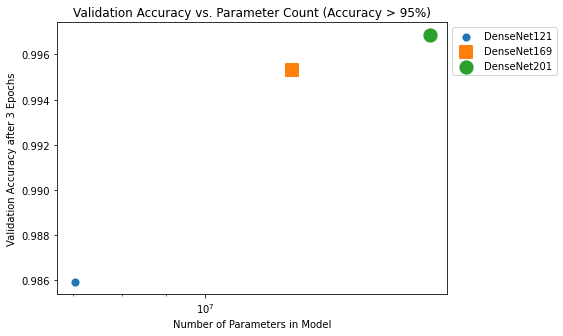

In [11]:
# Plot validation accuracy versus number of parameters for each model
benchmark_df = pd.DataFrame(model_benchmarks)
benchmark_df.sort_values('num_model_params', inplace=True)
benchmark_df = benchmark_df[benchmark_df['validation_accuracy'] > 0.95]

# Loop over each row and plot the num_model_params vs validation_accuracy
markers=[".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",4,5,6,7,8,9,10,11]
plt.figure(figsize=(7,5))
for row in benchmark_df.itertuples():
    plt.scatter(row.num_model_params, row.validation_accuracy, label=row.model_name, marker=markers[row.Index], s=150, linewidths=2)
    
plt.xscale('log')
plt.xlabel('Number of Parameters in Model')
plt.ylabel('Validation Accuracy after 3 Epochs')
plt.title('Validation Accuracy vs. Parameter Count (Accuracy > 95%)')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left');

## Training final model
With the MobileNetV2 base model selected, I retrained it using all training images and with a more complex head that included 4 fully-connected dense layers and a dropout layer before the output layer. This worked out well, as the final model performed with 99.8% testing accuracy. 

At this point, I stopped searching for a higher performance model and did not tune the model further, as it seemed that any improvements in accuracy would be minor relative to the amount of time it would take to achieve it. However, based on the plot below of accuracy versus operations for common CNN models, I'm confident that it would be difficult to find a significantly better performing model for this application [1].

![alt text](https://miro.medium.com/max/566/1*Bfm3lhmIfQzyJAmFsL_71Q.png)

One shortcoming of this model is that it was not trained to reject images of non-gestures. Therefore, it will attempt to classify an image of a giraffe rather than reporting "Not recognized." With more time, I would feed the model instances of non-hand-gestures and train it to reject these images rather than label them with whichever of the available hand-gestures they most closely resemble. 

Sources
- [1] https://arxiv.org/pdf/1810.00736.pdf

Epoch 1/20
490/490 [==============================] - 590s 1s/step - loss: 0.7617 - categorical_accuracy: 0.7736 - val_loss: 0.0449 - val_categorical_accuracy: 0.9856
INFO:tensorflow:Assets written to: C:\Users\clemo\git\gesture_recognition\data_collection_model_preparation\models\assets

 Validation loss: 0.04492228850722313, acc: 0.9856404662132263 


 Training loss: 0.03080410324037075, acc: 0.9894683361053467 


 Testing loss: 0.04595395177602768, acc: 0.9836856722831726 



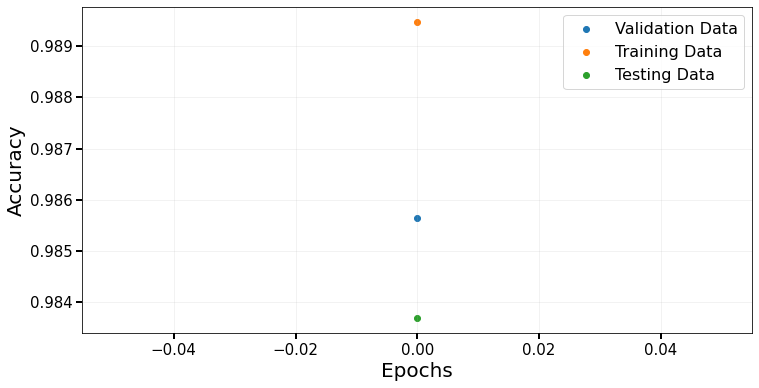

Epoch 2/20
490/490 [==============================] - 537s 1s/step - loss: 0.0477 - categorical_accuracy: 0.9872 - val_loss: 0.0116 - val_categorical_accuracy: 0.9966
INFO:tensorflow:Assets written to: C:\Users\clemo\git\gesture_recognition\data_collection_model_preparation\models\assets

 Validation loss: 0.011556676588952541, acc: 0.9965537190437317 


 Training loss: 0.006364087108522654, acc: 0.9981489777565002 


 Testing loss: 0.01602034643292427, acc: 0.9948299527168274 



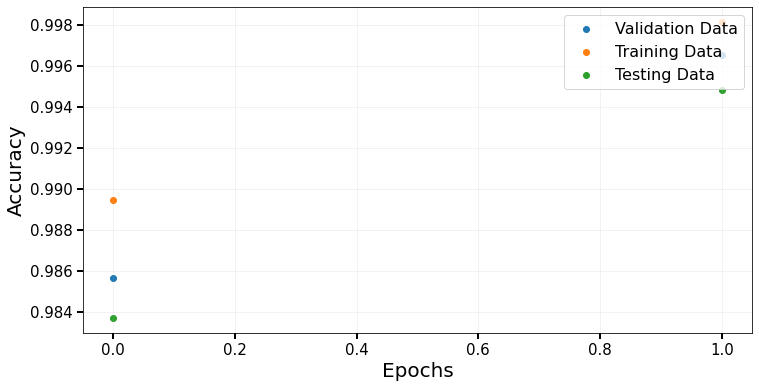

Epoch 3/20
490/490 [==============================] - 553s 1s/step - loss: 0.0268 - categorical_accuracy: 0.9923 - val_loss: 0.0200 - val_categorical_accuracy: 0.9957

 Validation loss: 0.019976381212472916, acc: 0.9956921339035034 


 Training loss: 0.003406532807275653, acc: 0.9990744590759277 


 Testing loss: 0.01173408329486847, acc: 0.9965533018112183 



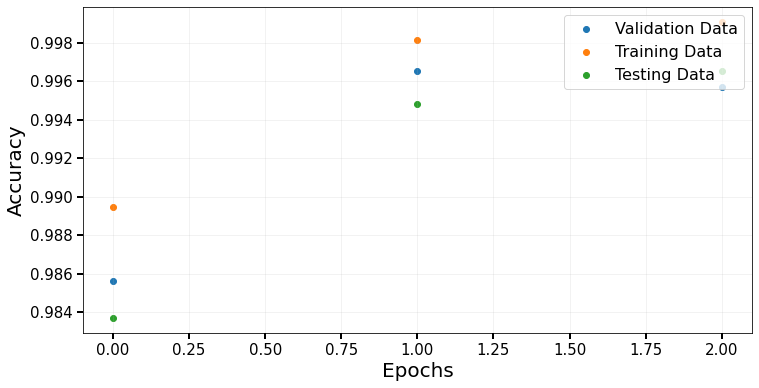

Epoch 4/20
490/490 [==============================] - 548s 1s/step - loss: 0.0169 - categorical_accuracy: 0.9953 - val_loss: 0.0121 - val_categorical_accuracy: 0.9966

 Validation loss: 0.012138447724282742, acc: 0.9965537190437317 


 Training loss: 0.004717184696346521, acc: 0.9986914992332458 


 Testing loss: 0.014922143891453743, acc: 0.9958639740943909 



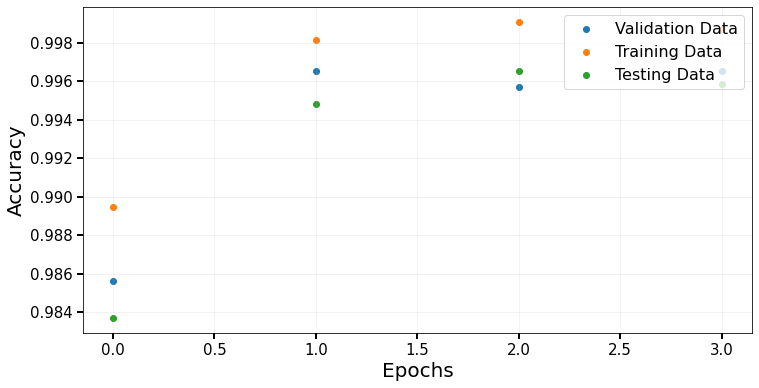

Epoch 5/20
490/490 [==============================] - 549s 1s/step - loss: 0.0064 - categorical_accuracy: 0.9984 - val_loss: 0.0104 - val_categorical_accuracy: 0.9977
INFO:tensorflow:Assets written to: C:\Users\clemo\git\gesture_recognition\data_collection_model_preparation\models\assets

 Validation loss: 0.010447192005813122, acc: 0.9977024793624878 


 Training loss: 0.002271956531330943, acc: 0.9993616938591003 


 Testing loss: 0.009606336243450642, acc: 0.998046875 



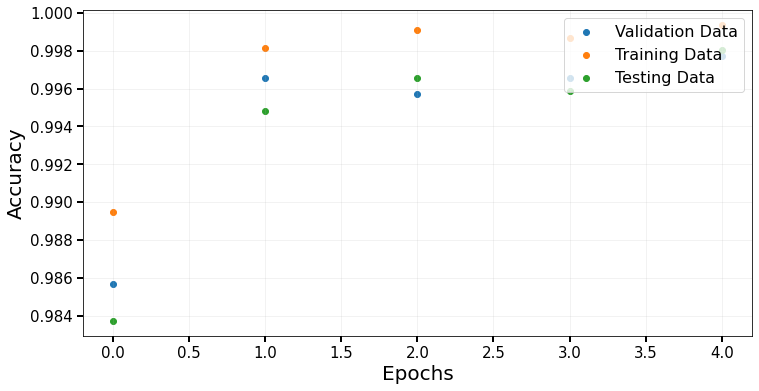

Epoch 6/20
490/490 [==============================] - 545s 1s/step - loss: 0.0145 - categorical_accuracy: 0.9965 - val_loss: 0.0138 - val_categorical_accuracy: 0.9960

 Validation loss: 0.013781392946839333, acc: 0.9959793090820312 


 Training loss: 0.004343366716057062, acc: 0.9982766509056091 


 Testing loss: 0.017768874764442444, acc: 0.9958639740943909 



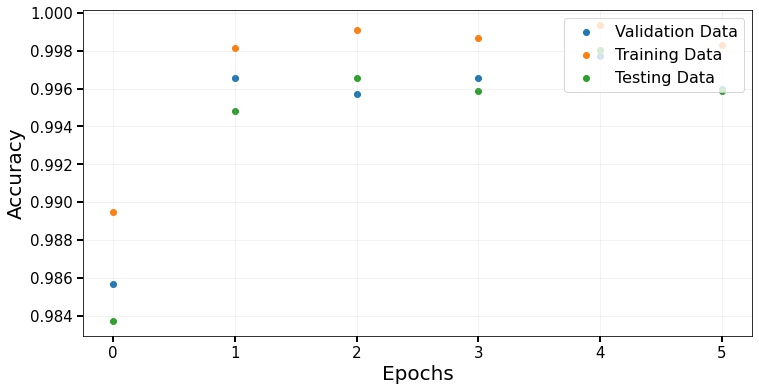

Epoch 7/20
490/490 [==============================] - 546s 1s/step - loss: 0.0097 - categorical_accuracy: 0.9977 - val_loss: 0.0020 - val_categorical_accuracy: 0.9991
INFO:tensorflow:Assets written to: C:\Users\clemo\git\gesture_recognition\data_collection_model_preparation\models\assets

 Validation loss: 0.0020370588172227144, acc: 0.9991384148597717 


 Training loss: 0.00015215633902698755, acc: 0.9999681115150452 


 Testing loss: 0.008906850591301918, acc: 0.997931957244873 



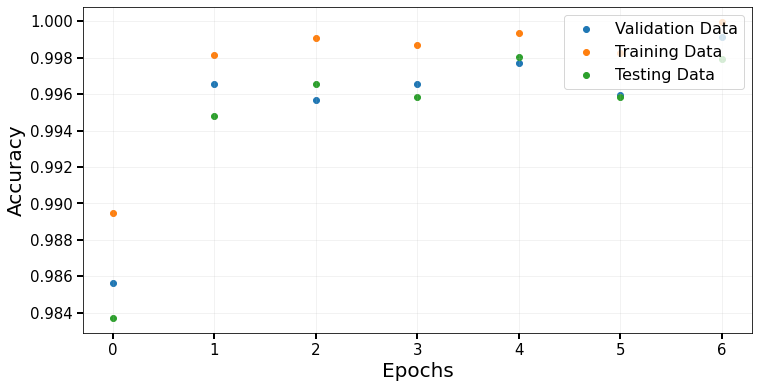

Epoch 8/20
490/490 [==============================] - 546s 1s/step - loss: 0.0101 - categorical_accuracy: 0.9974 - val_loss: 0.0057 - val_categorical_accuracy: 0.9980

 Validation loss: 0.005664655473083258, acc: 0.9979896545410156 


 Training loss: 0.0010950580472126603, acc: 0.9997127652168274 


 Testing loss: 0.008564566262066364, acc: 0.9975873231887817 



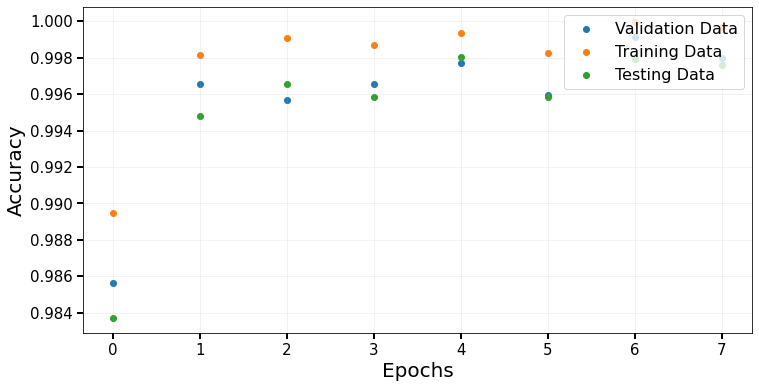

Epoch 9/20
490/490 [==============================] - 553s 1s/step - loss: 0.0025 - categorical_accuracy: 0.9995 - val_loss: 0.0163 - val_categorical_accuracy: 0.9960

 Validation loss: 0.016252664849162102, acc: 0.9959793090820312 


 Training loss: 0.008893669582903385, acc: 0.9976383447647095 


 Testing loss: 0.024030277505517006, acc: 0.9936810731887817 



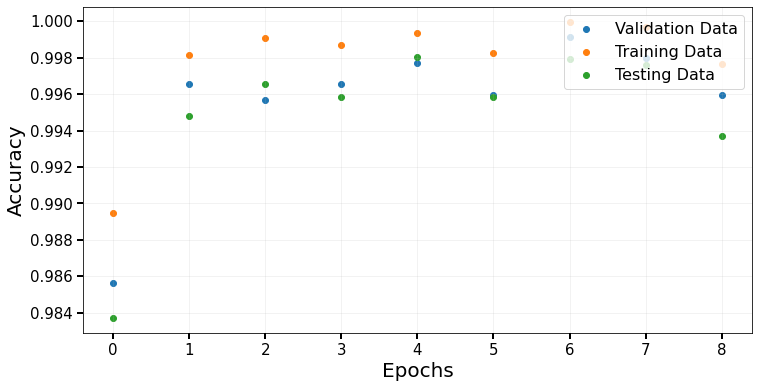

Epoch 10/20
490/490 [==============================] - 557s 1s/step - loss: 0.0168 - categorical_accuracy: 0.9957 - val_loss: 0.0099 - val_categorical_accuracy: 0.9974

 Validation loss: 0.009931780397891998, acc: 0.99741530418396 


 Training loss: 0.0018956639105454087, acc: 0.9993616938591003 


 Testing loss: 0.014069261029362679, acc: 0.9964384436607361 



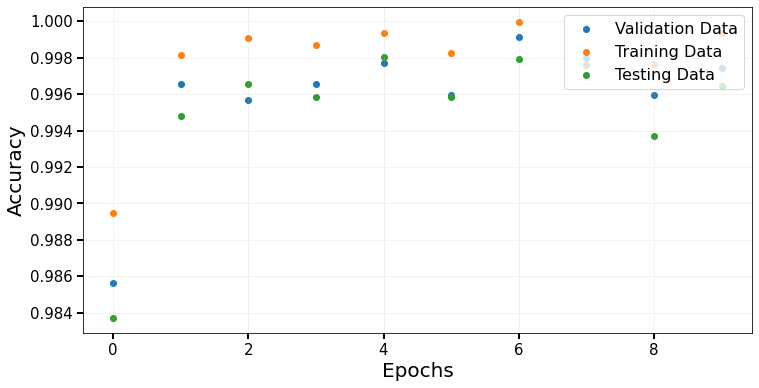

Epoch 11/20
490/490 [==============================] - 556s 1s/step - loss: 0.0062 - categorical_accuracy: 0.9983 - val_loss: 0.0046 - val_categorical_accuracy: 0.9980

 Validation loss: 0.004625814966857433, acc: 0.9979896545410156 


 Training loss: 0.000709784624632448, acc: 0.9998084902763367 


 Testing loss: 0.011074304580688477, acc: 0.9982766509056091 



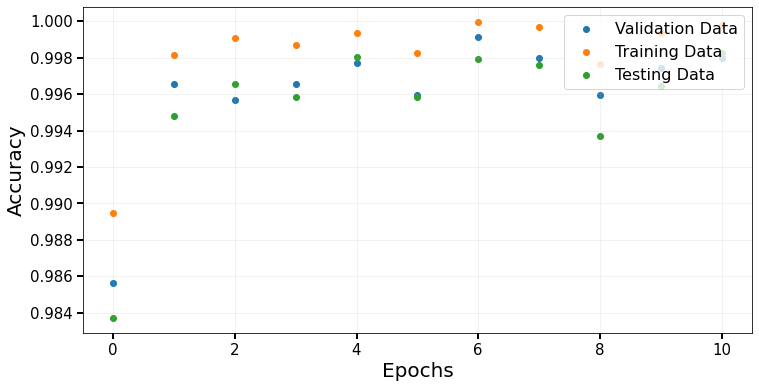

Epoch 12/20
490/490 [==============================] - 541s 1s/step - loss: 0.0053 - categorical_accuracy: 0.9987 - val_loss: 0.0026 - val_categorical_accuracy: 0.9989

 Validation loss: 0.002643788466230035, acc: 0.9988512396812439 


 Training loss: 0.0021826892625540495, acc: 0.9995213150978088 


 Testing loss: 0.008083036169409752, acc: 0.9978170990943909 



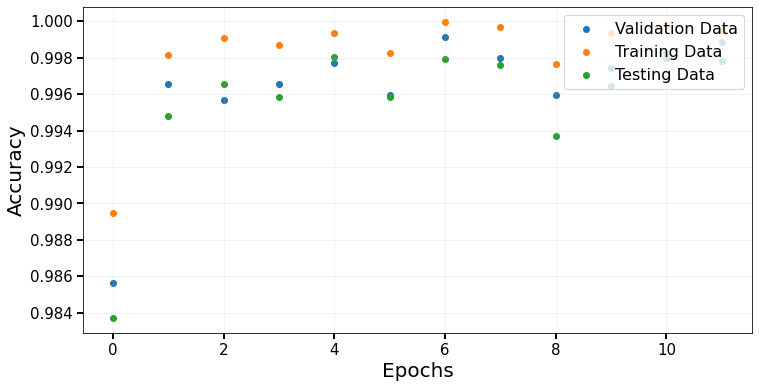

Epoch 13/20
490/490 [==============================] - 541s 1s/step - loss: 0.0039 - categorical_accuracy: 0.9993 - val_loss: 0.0123 - val_categorical_accuracy: 0.9963

 Validation loss: 0.012268404476344585, acc: 0.9962664842605591 


 Training loss: 0.002788123907521367, acc: 0.9991702437400818 


 Testing loss: 0.009660545736551285, acc: 0.9972426295280457 



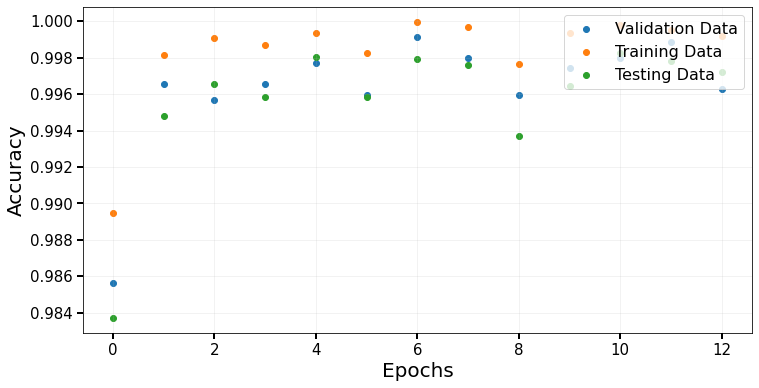

Epoch 14/20
490/490 [==============================] - 539s 1s/step - loss: 0.0083 - categorical_accuracy: 0.9982 - val_loss: 0.0055 - val_categorical_accuracy: 0.9989

 Validation loss: 0.005528606008738279, acc: 0.9988512396812439 


 Training loss: 0.0007004602812230587, acc: 0.9999042749404907 


 Testing loss: 0.007878150790929794, acc: 0.9982766509056091 



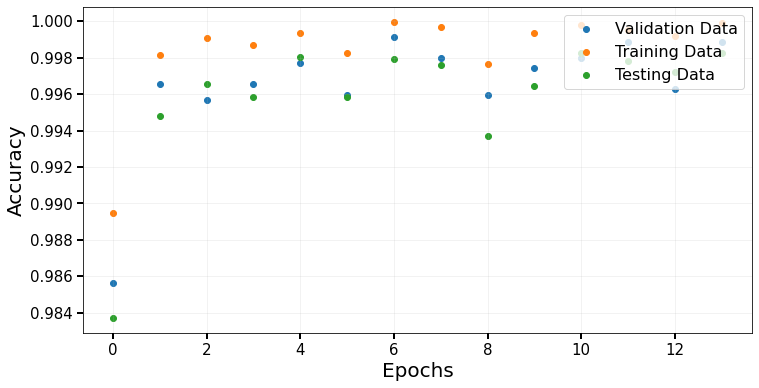

Epoch 15/20
490/490 [==============================] - 538s 1s/step - loss: 3.7200e-04 - categorical_accuracy: 0.9998 - val_loss: 0.0116 - val_categorical_accuracy: 0.9960

 Validation loss: 0.011550761759281158, acc: 0.9959793090820312 


 Training loss: 0.0031585884280502796, acc: 0.9991064071655273 


 Testing loss: 0.00850868970155716, acc: 0.9966682195663452 



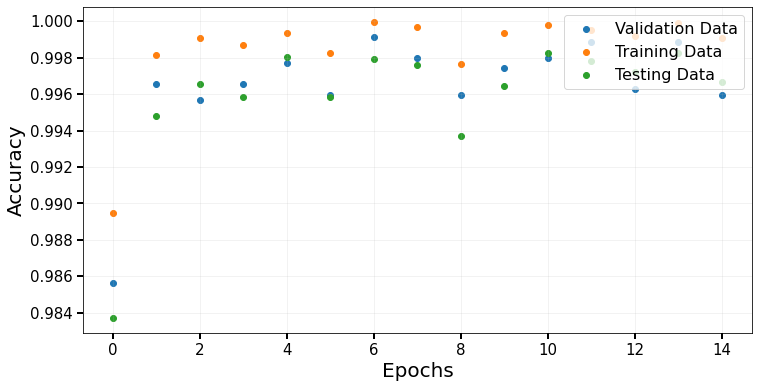

Epoch 16/20
490/490 [==============================] - 537s 1s/step - loss: 0.0186 - categorical_accuracy: 0.9959 - val_loss: 0.0066 - val_categorical_accuracy: 0.9983

 Validation loss: 0.006645597517490387, acc: 0.9982768297195435 


 Training loss: 0.0008259558817371726, acc: 0.9997127652168274 


 Testing loss: 0.01080353558063507, acc: 0.9970128536224365 



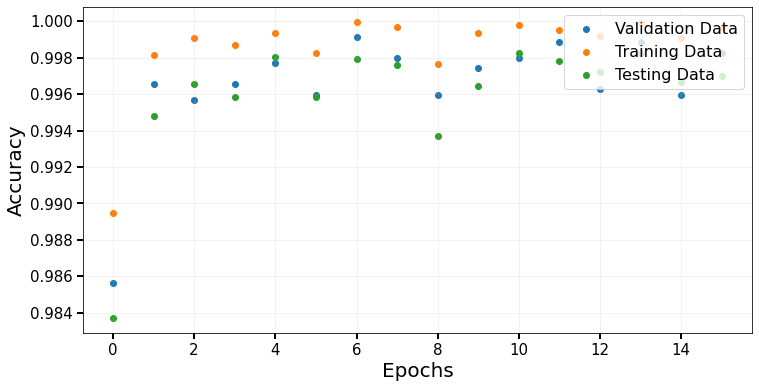

Epoch 17/20
490/490 [==============================] - 536s 1s/step - loss: 1.3881e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0047 - val_categorical_accuracy: 0.9991
Restoring model weights from the end of the best epoch.

 Validation loss: 0.0020370588172227144, acc: 0.9991384148597717 


 Training loss: 0.00015215633902698755, acc: 0.9999681115150452 


 Testing loss: 0.008906850591301918, acc: 0.997931957244873 



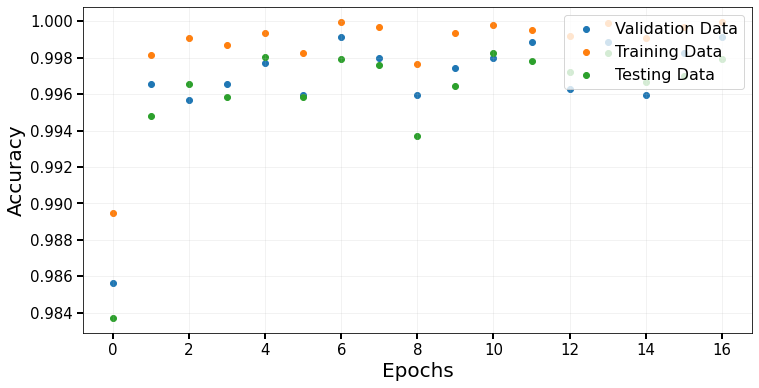

Epoch 00017: early stopping
[INFO] Model training took 21756.66126894951 seconds with 31334 data points and 20 epochs.


In [33]:
import time
from keras.applications import MobileNetV2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from sklearn.model_selection import train_test_split

def create_model(height, width, num_categories):
    """Create and return new model.

    Args:
        height (int): Height of image 
        width (int): Width of image
        num_categories (int): Number of gestures to predict 

    Returns:
        model (Tensorflow functional model): built model
    """
    
    # Fetch base model 
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(height, width, 3))

    # Add top to model
    base = base_model.output
    flat = Flatten()(base)
    fc1 = Dense(128, activation='relu', name='fc1')(flat)
    fc2 = Dense(128, activation='relu', name='fc2')(fc1)
    fc3 = Dense(128, activation='relu', name='fc3')(fc2)
    drop = Dropout(0.5)(fc3)
    fc4 = Dense(64, activation='relu', name='fc4')(drop)
    out = Dense(num_categories, activation='softmax')(fc4)
    model = Model(inputs=base_model.input, outputs=out)

    # Train top layers only
    for layer in base_model.layers:
        layer.trainable = False

    return model

# split training data into testing and validation sets
X_train, X_test, y_train, y_test = train_test_split(X_data_all, y_data_all, test_size=0.2, stratify=y_data_all)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train)

# maximum number of epochs for model evaulation. 
max_epochs = 20

# callback functions
model_dir = os.path.join(os.getcwd(), 'models')
model_checkpoint = ModelCheckpoint(filepath=model_dir, save_best_only=True)

# For this model's application, validation accuracy seems like the most important metric to maximize because it places equal 
# importance on minimizing FP and FN rates rather than just minimizing FP (as with precision) or FN (as with recall)
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', 
                            min_delta=0,
                            patience=10,
                            verbose=1,
                            mode='auto',
                            restore_best_weights=True)

# create model
height = X_train.shape[1]
width = X_train.shape[2]
num_categories = y_train.shape[1]
try: 
    assert X_train.shape[3] == 3
except AssertionError:
    print(f'[ERROR] Training data has {X_train.shape[3]} color layers. Model requires 3.')
model = create_model(height, width, num_categories)
model.compile(
    optimizer='Adam', 
    loss='categorical_crossentropy', 
    metrics=['categorical_accuracy'], 
    )

# monitor accuracy on validation, training, and testing data after each epoch
import matplotlib.pyplot as plt
class EpochAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, val_data, train_data, test_data):
        self.val_data = val_data
        self.train_data = train_data
        self.test_data = test_data
    def on_epoch_end(self, epoch, logs={}):
        epochs.append(epoch)
        # compute accuracy with validation data
        x, y = self.val_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        val_acc_results.append(acc)
        print('\n Validation loss: {}, acc: {} \n'.format(loss, acc))
        ;
        # compute accuracy with training data
        x, y = self.train_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        train_acc_results.append(acc)
        print('\n Training loss: {}, acc: {} \n'.format(loss, acc))
        
        # compute accuracy with testing data
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        test_acc_results.append(acc)
        print('\n Testing loss: {}, acc: {} \n'.format(loss, acc)) 

        # update plot
        fig, ax = plt.subplots(figsize= (12,6))
        ax.scatter(epochs, val_acc_results, label='Validation Data')
        ax.scatter(epochs, train_acc_results, label='Training Data')
        ax.scatter(epochs, test_acc_results, label='Testing Data')
        ax.set_xlabel('Epochs', fontsize=20)
        ax.set_ylabel('Accuracy', fontsize=20)
        ax.tick_params(labelsize=15, labelrotation=0, grid_alpha=0.2, axis='both', which='major', direction='out', length=6, width=2, left=True, bottom=True)
        ax.grid(True)
        ax.legend(loc='upper right', fontsize=16)        
        plt.show()      

val_acc_results = []
train_acc_results = []
test_acc_results = []
epochs = []
start_time = time.time()
history = model.fit(X_train, y_train, epochs=max_epochs, batch_size=64, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping, model_checkpoint, EpochAccuracy((X_val, y_val), (X_train, y_train), (X_test, y_test))])
print(f'[INFO] Model training took {time.time() - start_time} seconds with {len(X_train)} data points and {max_epochs} epochs.')

In [34]:
# save model
training_date = datetime.datetime.now()
date = training_date.strftime("%Y-%m-%d_T%H_%M")
model_name = date + '.h5'
model_path = os.path.join(model_dir, model_name)
model.save(model_path)

# compile results
results_dict = {}
results_dict['epochs'] = epochs
results_dict['val_acc'] = val_acc_results
results_dict['train_acc'] = train_acc_results
results_dict['test_acc'] = test_acc_results

# save model and gestures map locally
file_name = date + '_results.json'
file_path = os.path.join(os.getcwd(), 'models', 'results', file_name)
with open(file_path, "w") as outfile:  
    json.dump(results_dict, outfile) 

### Evaluate model
After training the final model, I evaluated its classification performance on the test dataset. Amazingly, the model predicted gestures perfectly, resulting accuracy, recall, precision, and f1-scores of 1. This speaks to the strength of the pre-trained MobileNetV2 model and the impact clean data has on model performance. 

In [50]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(model, X_test, y_test, labels):
    """Evaluate model performance

    Args:
        model (Tensorflow functional model): trained model
        X_test (array): Array of arrays representing test images
        y_data (array): Array of arrays representing image classification category 
        labels (list): List of gestures

    Returns:
        df_report (Pandas dataframe): Resultant classification report
        df_confusion_matrix (Pandas dataframe): Resultant confusion matrix
    """

    start_time = time.time()

    # evaluate model performance on validation data
    all_preds = model.predict(X_test)
    y_pred = np.argmax(all_preds, axis=1).tolist()
    y_true = np.argmax(np.array(y_test), axis=1).tolist()
    
    # find misclassified instances and generate classification_report and confusion matrixj
    errors = []
    for i in range(len(y_pred)):
        if y_pred[i] != y_true[i]:
            error_tuple = (labels[y_pred[i]], labels[y_true[i]], X_test[i])
            errors.append(error_tuple)
    report = classification_report(y_true, y_pred, target_names=labels, zero_division=0, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    df_confusion_matrix = pd.DataFrame(confusion_matrix(y_true, y_pred), columns=labels, index=labels)   

    eval_time = time.time()-start_time
    print(f'[INFO] Model evaluation took {eval_time} seconds with {len(X_train)} data points. Average prediction time = {eval_time/len(X_train)}')
    
    return [df_report.round(3), df_confusion_matrix, errors]

# Compute and present model classification report and confusion matrix
labels = list(pd.DataFrame(list(gestures_dict.values()))[1])
[class_report, con_matrix, errors] = evaluate_model(model, X_test, y_test, labels)
print(class_report)
print(con_matrix)

[INFO] Model evaluation took 139.09250497817993 seconds with 31334 data points. Average prediction time = 0.004439028051898255
              precision  recall  f1-score   support
Palm              0.996   0.997     0.996  2176.000
L                 1.000   1.000     1.000  2176.000
Fist              0.997   0.998     0.997  2176.000
Thumb             0.999   0.998     0.998  2176.000
accuracy          0.998   0.998     0.998     0.998
macro avg         0.998   0.998     0.998  8704.000
weighted avg      0.998   0.998     0.998  8704.000
       Palm     L  Fist  Thumb
Palm   2169     0     5      2
L         1  2175     0      0
Fist      5     0  2171      0
Thumb     3     1     1   2171


Predicted gesture: Fist
Actual gesture: Palm


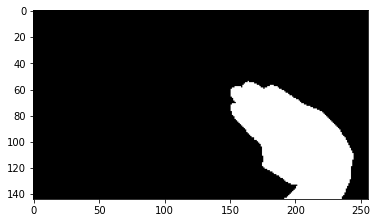

Predicted gesture: L
Actual gesture: Thumb


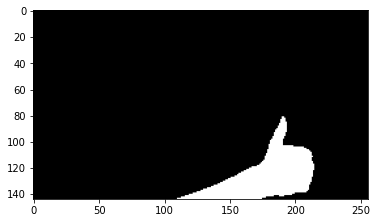

Predicted gesture: Fist
Actual gesture: Thumb


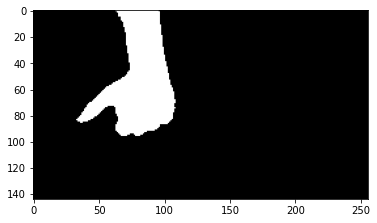

Predicted gesture: Palm
Actual gesture: L


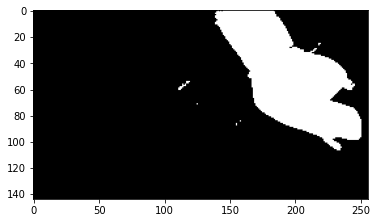

Predicted gesture: Thumb
Actual gesture: Palm


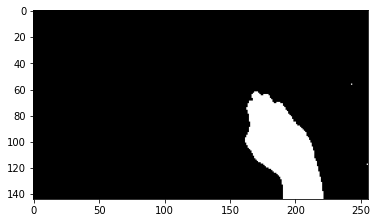

Predicted gesture: Thumb
Actual gesture: Palm


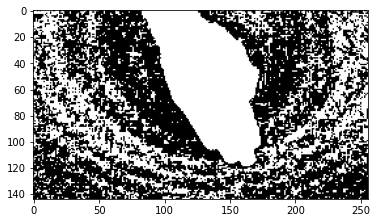

Predicted gesture: Palm
Actual gesture: Thumb


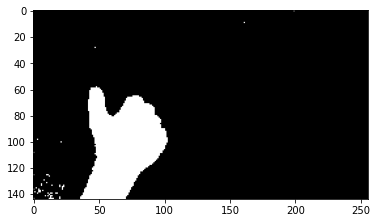

Predicted gesture: Palm
Actual gesture: Thumb


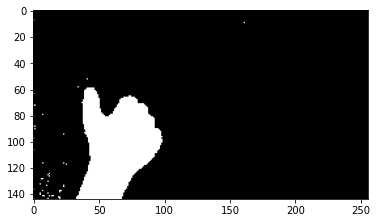

Predicted gesture: Fist
Actual gesture: Palm


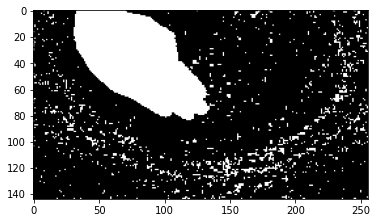

Predicted gesture: Palm
Actual gesture: Fist


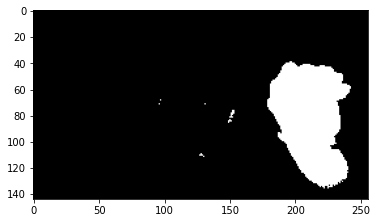

Predicted gesture: Palm
Actual gesture: Fist


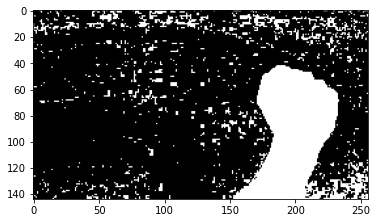

Predicted gesture: Palm
Actual gesture: Fist


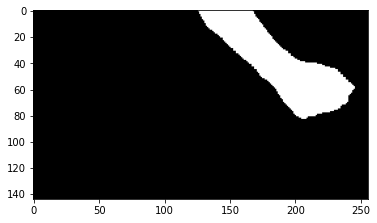

Predicted gesture: Palm
Actual gesture: Thumb


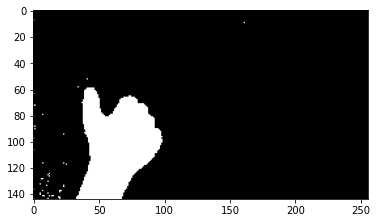

Predicted gesture: Palm
Actual gesture: Fist


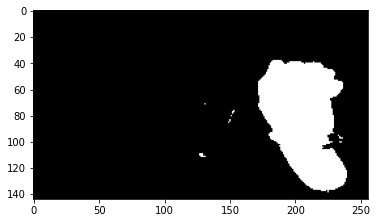

Predicted gesture: Fist
Actual gesture: Palm


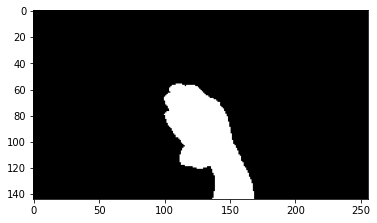

Predicted gesture: Fist
Actual gesture: Palm


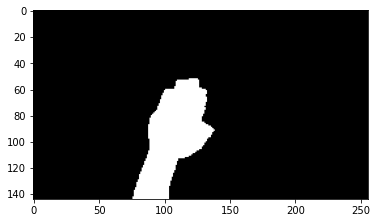

Predicted gesture: Palm
Actual gesture: Fist


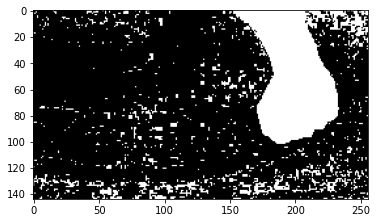

Predicted gesture: Fist
Actual gesture: Palm


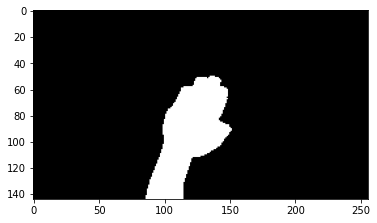

In [53]:
# Show error instances
for error in errors:
    print(f'Predicted gesture: {error[0]}')
    print(f'Actual gesture: {error[1]}')
    plt.imshow(error[2])
    plt.show()

### Predict gesture of sample image
After evaluating the final model, I tested its performance on a specific image to partially verify its functionality. 

In [54]:
sample_image = os.path.join(os.getcwd(), '2021_01_29_T19_16_17_open_palm_without_glove', 'poor_data', '176.jpg')

def predict_image(path):
    """Predict gesture in image model performance. Return F1-score, evaluation date, evaluation time, predicted values, and true values.

    Args:
        path (str): Path of test image

    Returns:
        pred_index (int): Index of predicted gesture
    """
    
    img = Image.open(path)
    img = np.array(img)
    img = np.array(img, dtype = 'float32')
    img = np.stack((img,)*3, axis=-1) # without comma, (X_data) is np.array not tuple
    img /= 255
    img.resize((1, 144, 256, 3))
    plt.figure()
    plt.imshow(img[0])
    pred_index = np.argmax(model.predict(img))
    return pred_index

pred_index = predict_image(sample_image)
pred_gest = pd.DataFrame(list(gestures_dict.values())).iloc[pred_index][1]
print(pred_gest)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\clemo\\git\\gesture_recognition\\data_collection_model_preparation\\2021_01_29_T19_16_17_open_palm_without_glove\\poor_data\\176.jpg'